In [1]:
# uncomment for running in colab

# from google.colab import drive
# drive.mount("/content/drive")
# %cd /content/drive/MyDrive/noncausal-transformer/

In [2]:
from contextlib import nullcontext
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import torch.nn.functional as F
from model import DecoderTransformerStackICL, DecoderTransformerConfig
from icl_data import LinearGenerator 

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

context = nullcontext() if device == "mps" else torch.autocast(device)

print(f"using {device} device")

using mps device


In [3]:
OUT_DIR = "out"

MAX_ITERS = 500000
EVAL_INTERVAL = 1

N_DIM = 20

BLOCK_SIZE = N_DIM * 4
BATCH_SIZE = 128

MIN_LR = [1e-4, 1e-3, 1e-4]
MAX_LR = [1e-5, 1e-4, 1e-4]
WARMUP_ITERS = 1000
LR_DECAY_ITERS = MAX_ITERS - WARMUP_ITERS

In [4]:
model_architectures = {
    "tiny": {
        "n_embd": 64,
        "n_layer": 3,
        "n_head": 2,
    },
    "small": {
        "n_embd": 128,
        "n_layer": 6,
        "n_head": 4,
    },
    "standard": {
        "n_embd": 256,
        "n_layer": 12,
        "n_head": 8,
    }
}

In [5]:
model_architecture = model_architectures["tiny"]

causal_config = DecoderTransformerConfig(
    block_size=BLOCK_SIZE,
    n_layer=model_architecture["n_layer"],
    n_head=model_architecture["n_head"],
    n_embd=model_architecture["n_embd"],
    n_dim=N_DIM,
    is_causal=True,
    loss_fn=F.mse_loss,
)

In [6]:
data_generator = LinearGenerator(N_DIM, 1)

In [7]:
def get_lr(iter_num: int, k: int) -> float:
    if iter_num < WARMUP_ITERS:
        return MAX_LR[k] * iter_num / WARMUP_ITERS
    
    if iter_num > LR_DECAY_ITERS:
        return MIN_LR[k]
    
    decay_ratio = (iter_num - WARMUP_ITERS) / (LR_DECAY_ITERS - WARMUP_ITERS)
    assert 0 <= decay_ratio and decay_ratio <= 1
    coeff = 0.5 * (1.0 + np.cos(np.pi * decay_ratio))
    return MIN_LR[k] + coeff * (MAX_LR[k] - MIN_LR[k])

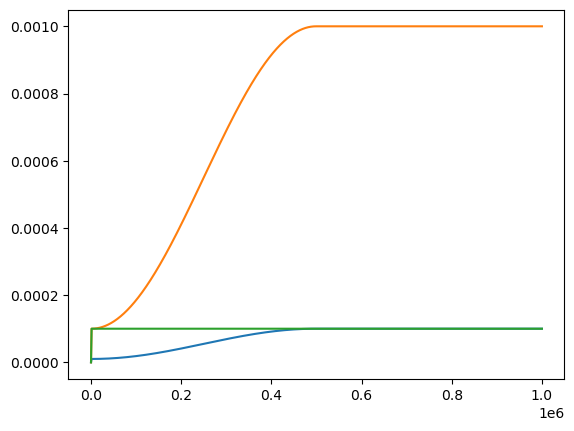

In [8]:
lrs = [[get_lr(i, k) for i in range(MAX_ITERS * 2)] for k in range(3)]

plt.plot(lrs[0], label="0")
plt.plot(lrs[1], label="1")
plt.plot(lrs[2], label="2")
plt.show()

In [9]:
models = [DecoderTransformerStackICL(causal_config).to(device) for _ in range(3)]

with torch.no_grad():
    for (n1, p1), (n2, p2), (n3, p3) in zip(*[m.named_parameters() for m in models]):
        assert n1 == n2 and n1 == n3
        p1.copy_(p3)
        p2.copy_(p3)
        assert torch.all(p1 == p2) and torch.all(p1 == p3)

optimizers = [m.configure_optimizers(
    weight_decay=0.1, 
    learning_rate=MIN_LR[i], 
    betas=(0.9, 0.99), 
    device_type=device,
) for i, m in enumerate(models)]

In [10]:
models_and_optimizers = [(models[i], optimizers[i]) for i in range(3)]
losses = [[], [], []]

In [12]:
t0 = time.time()

for i in range(2):
    data = data_generator.generate_batch(BATCH_SIZE, 40).to(device)
    forward_idxs = [i for i in range(data.shape[1]) if i % 2 == 0]
    
    x = data[:, :-1, :]
    y = data[:, 1:, :]
    
    for k, (model, optimizer) in enumerate(models_and_optimizers):
        lr = get_lr(i, k)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
        
        with context:
            y_hat, loss = model(x, y, backward=True, 
                                forward_idxs=forward_idxs, fast_backward=True)

        optimizer.step()
        optimizer.zero_grad()

        losses[k].append(loss.detach().cpu())
    
    if (i + 1) % EVAL_INTERVAL == 0:
        print(f"{f'[{i + 1}]':8}", end="")

        dt = time.time() - t0
        t0 = time.time()

        for k in range(3):
            loss = np.mean(losses[k][-EVAL_INTERVAL:])
            print(f"loss[{k}]: {loss:.3f}", end=", ")

        print(f"time: {dt:.1f}s")

[1]     loss[0]: 20.530, loss[1]: 20.530, loss[2]: 20.530, time: 0.7s
[2]     loss[0]: 20.146, loss[1]: 20.119, loss[2]: 20.119, time: 0.1s
